In [1]:
# objective: generate the particle size structure for the CMIP6 models
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import glob,os,subprocess
import IPython.display as display
import math
from datetime import datetime as dt
%matplotlib inline

In [2]:
from scipy.stats import linregress

In [3]:
carbon_molar_mass = 12.011 # g/mol

## Pre step: read files, create lists for each group of files that we'll need.

In [4]:
# create pattern to load the files 
#model_list = [ 'cesm2', 'cmcc', 'cnrm', 'gfdl',  'giss', 'ipsl', 'ukesm'] #

depth_list = ['0-100', '100-200']

p_categories = ['phymisc', 'phydiat', 'zmeso', 'zmicro'] # 'phymisc', removing this to see what happens with slope

phyto_categories = ['phydiat', 'phydiaz', 'phypico', 'phymisc', 'phycalc']

zoo_categories = ['zmeso', 'zmicro']

models_same = ['cmcc', 'cnrm', 'ipsl', 'ukesm']

pathBase='/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid' #path to folder

files = os.listdir(pathBase)
files=['.'.join([os.path.join(pathBase,f)]) for f in files]
files_ukesm = [model for model in files if 'ukesm' in model]

chla_hist = '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_schl_gr_monthly_1965_2014.nc'
chla_ssp5 = '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_ssp585_schl_gr_monthly_2015_2100.nc'

print (files_ukesm)

['/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_mld_gr_monthly_1965_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phyc_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phyc_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phydiat_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phydiat_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phymisc_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phymisc_100-200_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_schl_gr_monthly_1965_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_zmeso_0-100_gr_monthly_1985_2014.nc', '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_zmeso_100-200_gr_mon

In [5]:
files_ssp585 = [x for x in files_ukesm if 'ssp585' in x and 'chlos' not in x and 'mld' not in x and 'tos' not in x and 'schl' not in x]

files_hist = [x for x in files_ukesm if 'hist' in x and 'chlos' not in x and 'mld' not in x and 'tos' not in x and 'schl' not in x]
files_hist


['/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phyc_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phyc_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phydiat_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phydiat_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phymisc_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_phymisc_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_zmeso_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_zmeso_100-200_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukesm_hist_zmicro_0-100_gr_monthly_1985_2014.nc',
 '/work/jyl/proj/CMIP6_size/CMIP6_output_regular_grid/ukes

## New section to change chla date format

In [6]:
chl_hist=xr.open_mfdataset(chla_hist)
chl_ssp5 =xr.open_mfdataset(chla_ssp5)
chl_hist#.mean(dim=('lat', 'lon')).schl.plot()

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 600)
Coordinates:
  * time     (time) float64 1.965e+03 1.965e+03 ... 2.015e+03 2.015e+03
Dimensions without coordinates: y, x
Data variables:
    Lat      (y) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    Lon      (x) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    schl     (time, y, x) float64 dask.array<chunksize=(600, 180, 360), meta=np.ndarray>
Attributes:
    creation_date:  17-Feb-2021 14:30:27
    _FillValue:     1e+20

In [7]:
chl_hist=chl_hist.assign_coords(lon=chl_hist.Lon, lat=chl_hist.Lat)
chl_hist = chl_hist.rename({'x': 'lon','y': 'lat'})
chl_hist=chl_hist.sel(time= slice(1985.0, 2015.0))
chl_ssp5=chl_ssp5.assign_coords(lon=chl_ssp5.Lon, lat=chl_ssp5.Lat)
chl_ssp5 = chl_ssp5.rename({'x': 'lon','y': 'lat'})
chl_ssp5=chl_ssp5.sel(time= slice(2070.0, 2100.0))
chl_hist

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 360)
Coordinates:
  * time     (time) float64 1.985e+03 1.985e+03 ... 2.015e+03 2.015e+03
  * lon      (lon) float64 dask.array<chunksize=(360,), meta=np.ndarray>
  * lat      (lat) float64 dask.array<chunksize=(180,), meta=np.ndarray>
Data variables:
    Lat      (lat) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    Lon      (lon) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
Attributes:
    creation_date:  17-Feb-2021 14:30:27
    _FillValue:     1e+20

In [8]:
chl_ssp5

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 360)
Coordinates:
  * time     (time) float64 2.07e+03 2.07e+03 2.07e+03 ... 2.1e+03 2.1e+03
  * lon      (lon) float64 dask.array<chunksize=(360,), meta=np.ndarray>
  * lat      (lat) float64 dask.array<chunksize=(180,), meta=np.ndarray>
Data variables:
    Lat      (lat) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    Lon      (lon) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
Attributes:
    creation_date:  17-Feb-2021 14:37:28
    _FillValue:     1e+20

## Change time format from 365_day to day-month-year

In [9]:
def change_date_format(chl_hist):
    chl_hist=chl_hist.assign_coords(year = np.trunc(chl_hist.time).astype(int))#.astype(int)
    chl_hist=chl_hist.assign_coords(day = ((chl_hist.time - chl_hist.year)*365).astype(int))
    chl_hist = chl_hist.where(chl_hist.day !=0, drop=True)
    chl_hist=chl_hist.assign_coords(year = chl_hist.year.astype(str))
    chl_hist=chl_hist.assign_coords(day = np.char.zfill(chl_hist.day.astype(str),3))
    chl_hist=chl_hist.assign_coords(time = np.char.add(np.char.add(chl_hist.year, '-'),chl_hist.day))
    chl_hist= chl_hist.drop_dims('day')
    chl_hist = chl_hist.drop('year', dim=None)
    chl_hist=chl_hist.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in chl_hist.time.values])
    chl_hist = chl_hist.sortby('time', ascending = True)
    return (chl_hist)

In [10]:
chl_hist = change_date_format(chl_hist)
chl_ssp5 = change_date_format(chl_ssp5)
chl_hist.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/ukesm_hist_schl_gr_monthly_1985_2014.nc')
chl_ssp5.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/ukesm_ssp585_schl_gr_monthly_2070_2100.nc')
chl_hist

<xarray.Dataset>
Dimensions:  (lat: 180, time: 360, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-15 1985-02-14 ... 2014-12-15
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    Lat      (lat, time) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    Lon      (lon, time) float64 dask.array<chunksize=(360, 360), meta=np.ndarray>
    schl     (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
Attributes:
    creation_date:  17-Feb-2021 14:30:27
    _FillValue:     1e+20

## Pre step: combine the different files of the plankton into one netcdf file

In [11]:
# combine historical data in one file and add variables by depth, and remove old datasets
ds_hist= xr.open_mfdataset(files_hist, combine = 'by_coords')

for i in ['phyc', 'phydiat', 'phymisc', 'zmicro', 'zmeso']:
    ds_hist[i+'_200']= ds_hist[i+'_200'].fillna(0)
    ds_hist[i +'_0_200'] = ds_hist[i +'_100'] + ds_hist[i+'_200']
    ds_hist = ds_hist.drop_vars([i+'_100', i+'_200'])
ds_hist=ds_hist.sel(time= slice(1985.0, 2015)) # some data earlier than 1984 had to be removed
ds_hist=ds_hist.sortby('lat', ascending=True)

In [12]:
#necessary step to make sure that cells with Nans are the same across the PFTs
ds_hist_mask = ~(np.isnan(ds_hist.phydiat_0_200) | np.isnan(ds_hist.phymisc_0_200) | np.isnan(ds_hist.zmicro_0_200) | np.isnan(ds_hist.zmeso_0_200))
ds_hist = ds_hist.where(ds_hist_mask)

## Step 1b. Compute total global carbon

In [13]:

area_path = '/work/m1c/GFDL_files/ocean_cobalt_omip_tracers_month_z_1x1deg.static.nc'
area_grid = xr.open_dataset(area_path)
# coordinates need to match with the previous files
area_grid.coords['lon'] = (area_grid.coords['lon'] + 180) % 360 - 180
area_grid = area_grid.sortby(area_grid.lon)
#area_grid = area_grid.sortby(area_grid.lat) 
#area_grid= area_grid.assign_coords(lat=(area_grid.lat * -1))
area_grid

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables:
    areacello  (lat, lon) float32 ...
    deptho     (lat, lon) float32 ...
    geolat     (lat, lon) float32 ...
    geolon     (lat, lon) float32 ...
    hfgeou     (lat, lon) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    sftof      (lat, lon) float32 ...
    wet        (lat, lon) float32 ...
Attributes:
    filename:                   ocean_cobalt_omip_tracers_month_z_1x1deg.stat...
    title:                      OMp5_IAF_BLING_baseline
    grid_type:                  regular
    grid_tile:                  N/A
    history:                    fregrid --standard_dimension --input_mosaic o...
    history_of_appended_files:  Thu Jan 31 02:22:00 2019: Appended file 18540...
    NCO:                        "4.6.4"
    code_version:               $Name: bronx-10_performance_z1l $
    external_variables:         areacello areacello

In [14]:
carbon_molar_mass = 12.011 # g/mol
# dictionary with total carbon
total_carbon_gC={}
total_carbon_gC['globalSum_gC']={}
total_carbon_gC['globalSum_gC']['phymisc'] = ((ds_hist.phymisc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['phydiat'] = ((ds_hist.phydiat_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['zmeso'] = ((ds_hist.zmeso_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC['globalSum_gC']['zmicro'] = ((ds_hist.zmicro_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC

{'globalSum_gC': {'phymisc': 529685068480858.4,
  'phydiat': 195182713050984.8,
  'zmeso': 289043015049246.4,
  'zmicro': 260897064183247.72}}

In [15]:
# transform the dictionary to a dataframe
biomass=pd.DataFrame.from_dict(total_carbon_gC)
biomass=biomass.reset_index()
biomass.columns.values[0]='name'
biomass

,name,globalSum_gC
0,phydiat,1.951827e+14
1,phymisc,5.296851e+14
2,zmeso,2.890430e+14
3,zmicro,2.608971e+14


## Step3: complete table with size classes 

In [16]:
sizes=np.linspace(np.log10(2),np.log10(2.*1000.),num=1000,endpoint=False)
#10**(sizes)
#sizes

In [17]:
dd=np.diff(sizes)[0]
sizes_min=10**(sizes-dd/2)
sizes_max=10**(sizes+dd/2)
size_range=[str(np.round(10**s,3))+': '+'['+str(np.round(x,3))+','+str(np.round(y,3))+')' for s,x,y in zip(sizes,sizes_min,sizes_max)]
#size_range

In [18]:
sizedf=pd.DataFrame([10**sizes]).transpose()
sizedf.columns=['sizes']
sizedf['phyto']= None
sizedf['zoo']= None
#sizedf.loc[sizedf.sizes < 10,'phyto']='smp'
sizedf.loc[(sizedf.sizes > 2) & (sizedf.sizes < 20),'phyto']='phymisc'
sizedf.loc[(sizedf.sizes > 20) & (sizedf.sizes < 100),'phyto']='phydiat' 
sizedf.loc[(sizedf.sizes > 10) & (sizedf.sizes < 200),'zoo']='zmicro'
sizedf.loc[(sizedf.sizes > 200) & (sizedf.sizes < 2000),'zoo']='zmeso'
#sizedf.loc[(sizedf.sizes > 2000) & (sizedf.sizes < 20000),'zoo']='lgz'
##this step is necessary to remove the empty categories when we are not considering phymisc



sizedf = sizedf.reset_index(drop=True)

#sizedf

In [19]:
# determine the degree of overlap between size bins. In COBALT (and perhaps other models) the degree of overlap might need to be determined following 
# Jessica's method

# the goal is to have repeated entries for a size class if it occurs across plantkon types:
sdfm = pd.melt(sizedf, id_vars='sizes',var_name='type',value_name='name')
sdfm = sdfm.dropna().reset_index(drop=True)
pd.set_option('display.max_rows',80)
#sdfm

In [20]:
# assign biovolume and amount of acrbon to each size bin
import math

sdfm['biovolume_um3']=(4/3)*math.pi*(sdfm.sizes/2)**3

sdfm['mg_carbon']=0

#non-diatoms, Menden-Deuer and Lessard 2000, double check these with Jessica, to ask if might be appropiate to use dinoflagellate fits
#also, why 0.216?? notice phymisc as non diatoms

# phymisc, which are non diatoms, treated as protists, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 < 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 >= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phymisc') & (sdfm.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


# zmicro, treated as protists, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='zmicro') & (sdfm.biovolume_um3 < 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='zmicro') & (sdfm.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm.loc[(sdfm.name=='zmicro') & (sdfm.biovolume_um3 >= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='zmicro') & (sdfm.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


#sdfm.loc[sdfm.name=='phymisc','mg_carbon']=0.216 * sdfm.loc[sdfm.name=='phymisc','biovolume_um3']**0.939 * 1e-9
#sdfm.loc[sdfm.name=='zmicro','mg_carbon']=0.216 * sdfm.loc[sdfm.name=='zmicro','biovolume_um3']**0.939 * 1e-9

# diatoms, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 <= 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 <= 3000),'mg_carbon']=10**(-0.541 + 0.811 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 > 3000),'biovolume_um3']
sdfm.loc[(sdfm.name=='phydiat') & (sdfm.biovolume_um3 > 3000),'mg_carbon']=10**(-0.933 + 0.881 * np.log10(tmp)) * 1e-9

# mesozooplankton, Pitt et al. 2013 will be deprecated, we will use Kiorboe (2013)/Maas et al. (2021) combo
#sdfm.loc[sdfm.name=='zmeso','mg_carbon']= 0.06281 * (sdfm.loc[sdfm.name=='zmeso','sizes']/1e3)**3
sdfm.loc[sdfm.name=='zmeso','mg_carbon'] = 0.055 * (sdfm.loc[sdfm.name=='zmeso','biovolume_um3']/1e9) # Maas et al. takes milimeters cubed (notice conversion) and returns dry mass in mg
sdfm.loc[sdfm.name=='zmeso','mg_carbon'] = 10**((np.log10(sdfm.loc[sdfm.name=='zmeso','mg_carbon'])-(-0.67))/0.96) # Kiorboe et al. takes dry mass in mg to wet mass in mg
sdfm.loc[sdfm.name=='zmeso','mg_carbon'] = (10**((0.95*np.log10(sdfm.loc[sdfm.name=='zmeso','mg_carbon']))-0.93))# Kiorboe et al. takes wet mass  and returns mass of carbon



## define the linear regressions for the PFTs that can use more than one allomentric relations due to its size range. For UKESM these are phymisc and zmicro:

## first, phymisc

In [21]:
df_phymisc = sdfm.loc[sdfm.name=='phymisc'].reset_index()
df_phymisc['pg_carbon'] = df_phymisc['mg_carbon']*1e9
df_phymisc

,index,sizes,type,name,biovolume_um3,mg_carbon,pg_carbon
0,0,2.013863,phyto,phymisc,4.276501,9.114570e-10,0.911457
1,1,2.027823,phyto,phymisc,4.366049,9.278466e-10,0.927847
2,2,2.041879,phyto,phymisc,4.457472,9.445310e-10,0.944531
3,3,2.056033,phyto,phymisc,4.550809,9.615153e-10,0.961515
4,4,2.070284,phyto,phymisc,4.646101,9.788051e-10,0.978805
...,...,...,...,...,...,...,...
328,328,19.410199,phyto,phymisc,3829.028592,5.006338e-07,500.633842
329,329,19.544744,phyto,phymisc,3909.206474,5.104712e-07,510.471152
330,330,19.680222,phyto,phymisc,3991.063239,5.205018e-07,520.501762
331,331,19.816639,phyto,phymisc,4074.634043,5.307295e-07,530.729471


In [22]:
slope_phymisc, intercept_phymisc, r_value_phymisc, p_value_phymisc, std_err_phymisc = linregress(x=np.log10(df_phymisc.biovolume_um3),y=np.log10(df_phymisc.pg_carbon))

In [23]:
slope_phymisc

0.8781925381243771

In [24]:
intercept_phymisc

-0.6121195903707675

## now zmicro

In [25]:
df_zmicro = sdfm.loc[sdfm.name=='zmicro'].reset_index()
df_zmicro['pg_carbon'] = df_zmicro['mg_carbon']*1e9
df_zmicro

,index,sizes,type,name,biovolume_um3,mg_carbon,pg_carbon
0,566,10.000691,zoo,zmicro,5.237073e+02,5.693983e-08,56.939835
1,567,10.070012,zoo,zmicro,5.346734e+02,5.796371e-08,57.963714
2,568,10.139814,zoo,zmicro,5.458692e+02,5.900600e-08,59.006004
3,569,10.210100,zoo,zmicro,5.572994e+02,6.006704e-08,60.067036
4,570,10.280873,zoo,zmicro,5.689690e+02,6.114715e-08,61.147148
...,...,...,...,...,...,...,...
429,995,193.655571,zoo,zmicro,3.802670e+06,3.263647e-04,326364.719034
430,996,194.997928,zoo,zmicro,3.882296e+06,3.327777e-04,332777.691076
431,997,196.349589,zoo,zmicro,3.963589e+06,3.393167e-04,339316.676158
432,998,197.710619,zoo,zmicro,4.046584e+06,3.459842e-04,345984.150400


In [26]:
slope_zmicro, intercept_zmicro, r_value_zmicro, p_value_zmicro, std_err_zmicro = linregress(x=np.log10(df_zmicro.biovolume_um3),y=np.log10(df_zmicro.pg_carbon))

In [27]:
slope_zmicro

0.9777610218978652

In [28]:
intercept_zmicro

-0.8777798361190512

## Now use these linear regressions to inform the functions from carbon to biovolume:

In [29]:
def g_carbon_to_biovol(x, v): # allometric relations based on Menden-Deuder and Lessard() for phymisc, zmicro and phydiat,  and Pitt et al. for zmeso. takes grams, converts to picograms
    if v =='phymisc':
        x_biovol = 10**((np.log10(x*1e12)-(intercept_phymisc))/slope_phymisc)
        
    elif v == 'zmicro':
        x_biovol = 10**((np.log10(x*1e12)-(intercept_zmicro))/slope_zmicro)
        
    elif v == 'phydiat':
        x_biovol = 10**((np.log10(x*1e12)-(-0.933))/0.881) # onnly one regressionn for diatoms since all diatoms here are >3000 um3


    elif v == 'zmeso':
        #x_micrometers = (10**((0.33*np.log10(x))-0.6))*10000 # to  ESD in micrometers. Notice that allometric relations for Pitt et al have on the y variable cm and the x variable carbon in grams
        #x_micrometers = 10**((np.log10(x*1e6)-(-0.698))/2.476)# This relationship is for Acartia tonsa from Mauchline (1999) grams of carbon converted to micrograms
        #x_micrometers = 10**((np.log10(x*1e6)-(-5.58))/2.23) # relationship from Rodriguez & Mullin (1986), Takes micrograms and returrs micrometers, does not work, over estimation of meso biomass
        #x_biovol=(4/3)*math.pi*(x_micrometers/2)**3 #from mcirometers to micrometers cubed
        
        #the next approach uses three equations: two from Kiorboe et al. (2013), to go from carbom mass to wet mass and finally to dry mass, and then from Maas et al. 2021 from dry mass to biovolume
        wet_mass = 10**((np.log10(x*1000)-(-0.93))/0.95) # takes miligrams of carbon and returns miligrams of wet weight Kiorboe et al. (2013)
        dry_mass = (10**((0.96*np.log10(wet_mass))-0.67))# takes miligrams of wet mass and returns miligrams of dry mass Kiorboe et al. (2013)
        x_biovol = ((dry_mass)/0.055)*1e9 #Maas et al (2021) appears to set the intercept to 0 and does not use a logarithmic function to relate these variables. Original equation: dry mass = 0.055*biovolume +0. This also includes conversion from mm3 to um3
        #x_biovol = 10**((np.log10(x*1e12)-(-0.665))/0.939)
    return x_biovol

In [30]:
global_um3_list = []
for n, v in enumerate(biomass.name.unique()):
    global_um3_list.append(g_carbon_to_biovol(biomass.globalSum_gC[n], v))
biomass['globalSum_um3'] = global_um3_list

In [31]:
biomass

,name,globalSum_gC,globalSum_um3
0,phydiat,1.951827e+14,7.954529e+30
1,phymisc,5.296851e+14,1.341920e+31
2,zmeso,2.890430e+14,1.493444e+28
3,zmicro,2.608971e+14,8.223397e+27


## Step 3. pull together and merge the overlapping size bins. The total global biovolume is split by the size bins


In [32]:

sdfm['globalSum_um3_split']=0
for s in p_categories:
    n=len(sdfm.loc[sdfm.name==s].index)
    print(s, n)
    sdfm.loc[sdfm.name==s,'globalSum_um3_split'] = np.tile(biomass.loc[biomass.name==s,'globalSum_um3']/n,n)
sdfm

phymisc 333
phydiat 233
zmeso 333
zmicro 434


,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phymisc,4.276501e+00,9.114570e-10,4.029791e+28
1,2.027823,phyto,phymisc,4.366049e+00,9.278466e-10,4.029791e+28
2,2.041879,phyto,phymisc,4.457472e+00,9.445310e-10,4.029791e+28
3,2.056033,phyto,phymisc,4.550809e+00,9.615153e-10,4.029791e+28
4,2.070284,phyto,phymisc,4.646101e+00,9.788051e-10,4.029791e+28
...,...,...,...,...,...,...
1328,1932.101758,zoo,zmeso,3.776492e+09,1.141779e-01,4.484816e+25
1329,1945.494448,zoo,zmeso,3.855570e+09,1.165436e-01,4.484816e+25
1330,1958.979971,zoo,zmeso,3.936304e+09,1.189582e-01,4.484816e+25
1331,1972.558971,zoo,zmeso,4.018728e+09,1.214229e-01,4.484816e+25


In [33]:
sdfm = sdfm.sort_values(by='biovolume_um3', ascending=True)

In [34]:
small_increment_biovol = (sdfm['biovolume_um3'][1]-sdfm['biovolume_um3'][0])/2 # small increment is used to define the maximum and minimum of the size range

In [35]:
# create log-spaced bins for mg_carbon
bins_biovol = np.logspace(np.log10(sdfm['biovolume_um3'].min()-small_increment_biovol), np.log10(sdfm['biovolume_um3'].max()+small_increment_biovol), 51)


# use pandas.cut to bin the data into log-spaced bins
sdfm['biovolume_um3_bin'] = pd.cut(sdfm['biovolume_um3'], bins=bins_biovol, include_lowest=False)
sdfm['bin_centers_biovol'] = sdfm['biovolume_um3_bin'].apply(lambda x:x.mid).astype(float) # this gets the mid point 
sdfm['bin_range_biovol'] = sdfm['biovolume_um3_bin'].apply(lambda x:x.length).astype(float)

#len(sdfm)

In [36]:
sdfm.head()

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split,biovolume_um3_bin,bin_centers_biovol,bin_range_biovol
0,2.013863,phyto,phymisc,4.276501,9.114570e-10,4.029791e+28,"(4.232, 6.401]",5.3165,2.169
1,2.027823,phyto,phymisc,4.366049,9.278466e-10,4.029791e+28,"(4.232, 6.401]",5.3165,2.169
2,2.041879,phyto,phymisc,4.457472,9.445310e-10,4.029791e+28,"(4.232, 6.401]",5.3165,2.169
3,2.056033,phyto,phymisc,4.550809,9.615153e-10,4.029791e+28,"(4.232, 6.401]",5.3165,2.169
4,2.070284,phyto,phymisc,4.646101,9.788051e-10,4.029791e+28,"(4.232, 6.401]",5.3165,2.169


In [37]:
len(sdfm)

1333

In [38]:
df_grouped_biovol = sdfm.groupby([ 'name', 'biovolume_um3_bin','bin_centers_biovol', 'bin_range_biovol']).agg(biovolume_um3=('biovolume_um3','mean'), globalSum_um3=('globalSum_um3_split','sum'),
                                                                                                             sizes=('sizes','mean'))


df_grouped_biovol = df_grouped_biovol.dropna().sort_values(by = ['sizes']).reset_index()
df_grouped_biovol['NB'] = df_grouped_biovol.globalSum_um3/df_grouped_biovol.bin_range_biovol
df_grouped_biovol.sizes = df_grouped_biovol.sizes.round(1)
df_grouped_biovol



,name,biovolume_um3_bin,bin_centers_biovol,bin_range_biovol,biovolume_um3,globalSum_um3,sizes,NB
0,phymisc,"(4.232, 6.401]",5.316500e+00,2.169000e+00,5.244268e+00,8.059581e+29,2.2,3.715805e+29
1,phymisc,"(6.401, 9.682]",8.041500e+00,3.281000e+00,7.937521e+00,8.059581e+29,2.5,2.456440e+29
2,phymisc,"(9.682, 14.646]",1.216400e+01,4.964000e+00,1.201392e+01,8.059581e+29,2.8,1.623606e+29
3,phymisc,"(14.646, 22.154]",1.840000e+01,7.508000e+00,1.818381e+01,8.059581e+29,3.3,1.073466e+29
4,phymisc,"(22.154, 33.51]",2.783200e+01,1.135600e+01,2.752231e+01,8.059581e+29,3.7,7.097201e+28
5,phymisc,"(33.51, 50.688]",4.209900e+01,1.717800e+01,4.165670e+01,8.059581e+29,4.3,4.691804e+28
6,phymisc,"(50.688, 76.672]",6.368000e+01,2.598400e+01,6.304997e+01,8.059581e+29,4.9,3.101748e+28
7,phymisc,"(76.672, 115.976]",9.632400e+01,3.930400e+01,9.542999e+01,8.059581e+29,5.7,2.050575e+28
8,phymisc,"(115.976, 175.429]",1.457025e+02,5.945300e+01,1.444391e+02,8.059581e+29,6.5,1.355622e+28
9,phymisc,"(175.429, 265.358]",2.203935e+02,8.992900e+01,2.186175e+02,8.059581e+29,7.5,8.962160e+27


In [39]:
bin_info = pd.DataFrame({
    'biovolume_um3_bin': np.sort(sdfm['biovolume_um3_bin'].unique()),
    'bin_centers_biovol': np.sort(sdfm['bin_centers_biovol'].unique())})

In [40]:
bin_info

,biovolume_um3_bin,bin_centers_biovol
0,"(4.232, 6.401]",5.316500e+00
1,"(6.401, 9.682]",8.041500e+00
2,"(9.682, 14.646]",1.216400e+01
3,"(14.646, 22.154]",1.840000e+01
4,"(22.154, 33.51]",2.783200e+01
5,"(33.51, 50.688]",4.209900e+01
6,"(50.688, 76.672]",6.368000e+01
7,"(76.672, 115.976]",9.632400e+01
8,"(115.976, 175.429]",1.457025e+02
9,"(175.429, 265.358]",2.203935e+02


## Calculate  total biomass and normalized biomass per size class

In [41]:
lat = ds_hist.lat
lon = ds_hist.lon
time = ds_hist.time
biovol_um3 = bin_info['bin_centers_biovol']
data = np.zeros((len(biovol_um3), len(time), len(lat), len(lon)))
biovolume_all = xr.DataArray(data, coords={'biovol_um3':biovol_um3, 'time':time, 'lat':lat, 'lon':lon},
            dims = ['biovol_um3', 'time', 'lat', 'lon'])


lat_NB = ds_hist.lat
lon_NB = ds_hist.lon
time_NB = ds_hist.time
biovol_um3_NB = bin_info['bin_centers_biovol']
data_NB = np.zeros((len(biovol_um3_NB), len(time_NB), len(lat_NB), len(lon_NB)))
biovolume_all_NB = xr.DataArray(data_NB, coords={'biovol_um3':biovol_um3_NB, 'time':time_NB, 'lat':lat_NB, 'lon':lon_NB},
            dims = ['biovol_um3', 'time', 'lat', 'lon'])

#time = ds.time
#data = np.zeros((len(time), len(mmolC), len(z_t_150m), len(nlat), len(nlon)))
#biomass_all = xr.DataArray(data, coords={'time':time, 'mass_mmolC':mmolC, 'z_t_150m':z_t_150m, 'nlat':nlat, 'nlon':nlon},
#            dims = ['time', 'mass_mmolC', 'z_t_150m', 'nlat', 'nlon'])




biovolume_all.shape

(50, 360, 180, 360)

In [42]:
biovolume_all_NB.shape

(50, 360, 180, 360)

In [43]:
def size_spectra(data_array,dataset, NB=False):
    for v in df_grouped_biovol['name'].unique():
        print(v)
        cobaltvar = v +'_0_200' # REMEMBER: it has to be with the integrated data variables, to remove depth dimensions
        x = dataset[cobaltvar]#.mean(dim='time') # average by time
        x = x.values * carbon_molar_mass # to g C
        x = g_carbon_to_biovol(x, v)

    
        # split up 
        n_split = len(df_grouped_biovol.loc[df_grouped_biovol.name==v].index)

        um_biovolume = df_grouped_biovol.loc[df_grouped_biovol.name==v,'bin_range_biovol'].values
        x_split = x / n_split

    
        x_rep = np.repeat(x_split[np.newaxis,...], n_split, axis=0)
    
        if NB==True:
            x_rep = x_rep / (um_biovolume[:,None,None,None]) # normalized biomass = integrated biomass / size-class

        # units are : um3 / m^2 / um3 ind-1

        print(np.nanmax(x_rep))
        # extract the indices corresponding to the bins where the plankton groups fall
        pft_bins=pd.unique(df_grouped_biovol.where(df_grouped_biovol.name==v).dropna().bin_centers_biovol)
        subset = bin_info[bin_info['bin_centers_biovol'].isin(pft_bins)]
        index_dims = subset.index.values
    
        # check lengths are the same
        if (n_split != len(index_dims)):
            print("Error: Dimension lengths are not the same")
            break
        #normalized biovolume
        biovolume_vals = data_array[index_dims,:,:,:].values
        biovolume_vals = biovolume_vals + x_rep
        # put into matrix
        data_array.values[index_dims,:,:,:] = biovolume_vals
    return(data_array)

In [44]:
biovolume_all = size_spectra(biovolume_all, ds_hist, NB=False)

phymisc
123894425981475.28
zmicro
6258051164430.285
phydiat
669304067074356.4
zmeso
20113266252093.195


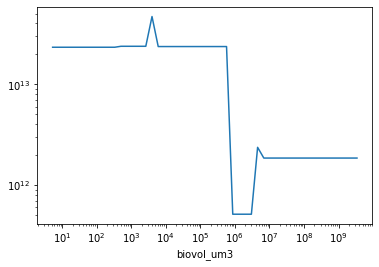

In [45]:
biovolume_all.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

## Get the total biovolume for only the size range included in PSSdb UVP+Zooscan

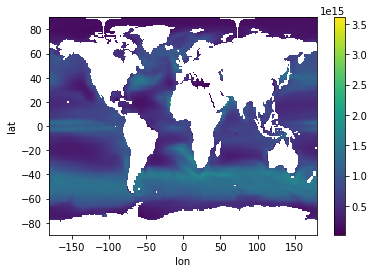

In [46]:
biovol_mask = ~np.isnan(biovolume_all.mean(dim=('biovol_um3')))
biovolume_all_subset= biovolume_all.where((biovolume_all['biovol_um3']>826400.0) & (biovolume_all['biovol_um3']<49100000000000.0)).sum(dim=['biovol_um3'])
biovolume_all= biovolume_all.sum(dim=['biovol_um3'])
biovolume_all = biovolume_all.where(biovol_mask)
biovolume_all_subset = biovolume_all_subset.where(biovol_mask)
biovolume_all.mean(dim=('time')).plot()

                

In [47]:
biovolume_all_NB = size_spectra(biovolume_all_NB, ds_hist, NB=True)

phymisc
57120528345539.56
zmicro
30414175496.96145
phydiat
410774001455.9935
zmeso
10864954.152284771


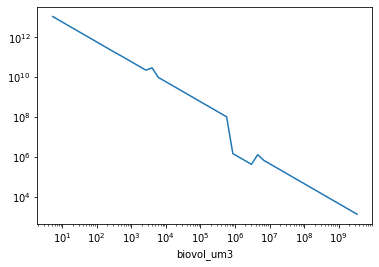

In [48]:
biovolume_all_NB.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

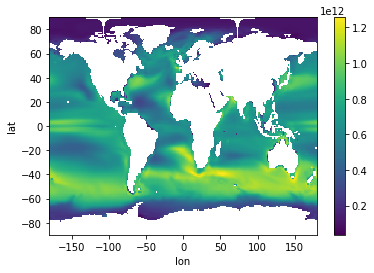

In [49]:
biovolume_all_NB.mean(dim=('time', 'biovol_um3')).plot()

In [50]:
# removing data from mediterranean and black sea
#biovolume_all.loc[dict(lat=biovolume_all.coords['lat'][(biovolume_all.coords['lat'] >= 30.5) & (biovolume_all.coords['lat'] <= 47.5)],
                                        #lon=biovolume_all.coords['lon'][(biovolume_all.coords['lon'] >= -5.5) & (biovolume_all.coords['lon'] <= 55.5)])]=float('nan') #

In [51]:
def calculate_size_spectra_slopes(data):
    data.values=np.log10(data.values)
    data = data.assign_coords(biovol_um3=np.log10(data.biovol_um3))
    cov_x = (data.biovol_um3.values - data.biovol_um3.mean().values)[:,None,None,None]
    cov_y = (data.values - data.mean(dim='biovol_um3').values[None,:,:,:])
    cov_xy = cov_x * cov_y
    covariance = np.nansum(cov_xy,axis=0)

    #variance = (data.mass_mgC.values.var() * (len(data.mass_mgC.values) - 1.))
    variance = np.nansum(cov_x**2, axis=0)

    betas = covariance / variance
    intercept_log = data.mean(dim='biovol_um3').values - (betas * data.biovol_um3.mean().values)
    intercept = 10**(data.mean(dim='biovol_um3').values - (betas * data.biovol_um3.mean().values))
    #print(betas.shape)
    #print(intercept.shape)
    #print(data.mass_mgC.values[:, None,None].shape)
    Y_pred = betas*(data.biovol_um3.values[:, None,None,None])+intercept_log
    ss_res = np.nansum((data.values - Y_pred)**2, axis = 0)
    ss_tot = np.nansum((cov_y)**2, axis = 0)
    R2 = 1-(ss_res/ss_tot)
    RMSE = (ss_res/data.biovol_um3.values.shape[0])**0.5
    #print(Y_pred.shape)
    #ss_tot = (data.values - data.mean(dim='mass_mgC').values[None,:,:])**2
    #ss_res = (data.values-Y_pred)
    #R2 = 1 - (ss_res / ss_tot)
    
    
    
    #betas = -betas # convention
    betas[betas == 0] = np.nan
    intercept[intercept ==0] = np.nan
    R2[R2 ==0] = np.nan
    RMSE[RMSE ==0] = np.nan
    
    return betas, intercept, R2, RMSE

In [52]:
betas_hist, intercept_hist, R2_hist, RMSE_hist = calculate_size_spectra_slopes(biovolume_all_NB)
betas_hist.shape

(360, 180, 360)

In [53]:
np.nanmean(betas_hist)

-1.2240542558334797

In [54]:
np.nanmax(betas_hist)

-0.9482011746074073

In [55]:
np.nanmin(betas_hist)

-2.808519166440192

In [56]:
biovolume_all_NB.values=10**(biovolume_all_NB.values)

In [57]:
#phymisc=g_carbon_to_biovol(((ds_hist.phymisc_0_200.values)*carbon_molar_mass), 'phymisc')
#phydiat=g_carbon_to_biovol(((ds_hist.phydiat_0_200.values)*carbon_molar_mass), 'phydiat')
#zmicro=g_carbon_to_biovol(((ds_hist.zmicro_0_200.values)*carbon_molar_mass), 'zmicro')
#zmeso=g_carbon_to_biovol(((ds_hist.zmeso_0_200.values)*carbon_molar_mass), 'zmeso')



## Get the slopes for each biome

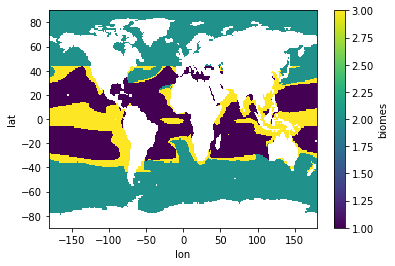

In [58]:
# load the biome mask
biome_mask = '/work/jyl/proj/CMIP6_models/ESM_Biomes/UKESM_historical_biomes_x1.nc'
biomes_hist = xr.open_dataset(biome_mask)
biomes_mask = ~np.isnan(biomes_hist.biomes)
biomes_hist['biomes'] = biomes_hist['biomes'].where((biomes_hist['lat'] < 44.5) & (biomes_hist['lat'] > -44.5), 2)
biomes_hist = biomes_hist.where(biomes_mask)
#biomes_hist = biomes_hist.assign_coords(lat=(biomes_hist.lat * -1))
biomes_hist.biomes.plot()

In [59]:

# add slopes to the biomes dataset
biomes_hist['chl'] = (('time', 'lat', 'lon'), chl_hist.schl.values)
biomes_hist['chl'].attrs = {"units": 'kg m-3', 'Description': 'Surface Mass Concentration of Total Phytoplankton expressed as Chlorophyll in Sea Water'}

biomes_hist['NB'] = biovolume_all_NB
biomes_hist['NB'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'normalized biovolume for each size class'}

#biomes_hist['total_biovolume_hist_full'] = biovolume_all
biomes_hist['total_biovolume_hist'] = biovolume_all_subset#(('time', 'lat', 'lon'),biovolume_all.values)
biomes_hist['total_biovolume_hist'] = biomes_hist.total_biovolume_hist.where(biomes_hist['total_biovolume_hist'] !=0)
biomes_hist['total_biovolume_hist'].attrs = {"units": 'um^3 ', 'Description': 'total biovolume from the size range of 116-2000 micrometers'}

biomes_hist['betas_hist'] = (('time', 'lat', 'lon'), betas_hist)
biomes_hist['betas_hist'].attrs = {"units": 'm^-2 m^-3', 'Description': 'Normalized biovolume size spectra slope'}

biomes_hist['intercept_hist'] = (('time', 'lat', 'lon'), intercept_hist)
biomes_hist['intercept_hist'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra intercept'}

biomes_hist['R2_hist'] = (('time', 'lat', 'lon'), R2_hist)
biomes_hist['R2_hist'].attrs = { 'Description': 'Normalized biovolume coefficient of determination'}

biomes_hist['RMSE_hist'] = (('time', 'lat', 'lon'), RMSE_hist)
biomes_hist['RMSE_hist'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra Root mean square error'}

#original_biomass_variables
biomes_hist['phymisc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.phymisc_0_200.values*carbon_molar_mass, 'phymisc'))
biomes_hist['phymisc'].attrs = {"units": 'um^3', 'Description': 'miscellaneous phytoplankton biovolume'}

biomes_hist['phydiat'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.phydiat_0_200.values*carbon_molar_mass, 'phydiat'))
biomes_hist['phydiat'].attrs = {"units": 'um^3', 'Description': 'diatom biovolume'}

biomes_hist['zmicro'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.zmicro_0_200.values*carbon_molar_mass, 'zmicro'))
biomes_hist['zmicro'].attrs = {"units": 'um^3', 'Description': 'microzooplankton biovolume'}

biomes_hist['zmeso'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_hist.zmeso_0_200.values*carbon_molar_mass, 'zmeso'))
biomes_hist['zmeso'].attrs = {"units": 'um^3', 'Description': 'mesozooplankton biovolume'}

biomes_hist['total_biovolume_full']=(('time', 'lat', 'lon'), biomes_hist.phymisc.values+biomes_hist.phydiat.values+biomes_hist.zmicro.values+biomes_hist.zmeso.values)
biomes_hist['total_biovolume_full'].attrs = {"units": 'um^3', 'Description': 'all plankton biovolume'}
                                          
#percentage total
biomes_hist['phymisc_per'] = (('time', 'lat', 'lon'), (biomes_hist.phymisc.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['phymisc_per'].attrs = {'Description': 'miscellaneous phytoplankton percentage of total biovolume'}                                        
                                          
biomes_hist['phydiat_per'] = (('time', 'lat', 'lon'),(biomes_hist.phydiat.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['phydiat_per'].attrs = {'Description': 'diatom percentage of total biovolume'}                                           
                                          
biomes_hist['zmicro_per'] = (('time', 'lat', 'lon'),(biomes_hist.zmicro.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['zmicro_per'].attrs = {'Description': 'microzooplankton percentage of total biovolume'} 

biomes_hist['zmeso_per'] = (('time', 'lat', 'lon'),(biomes_hist.zmeso.values/biomes_hist.total_biovolume_full.values)*100)
biomes_hist['zmeso_per'].attrs = {'Description': 'mesozooplankton percentage of total biovolume'} 

#total biovolume
biomes_hist['phyc'] = (('time', 'lat', 'lon'), biomes_hist.phymisc.values+biomes_hist.phydiat.values)
biomes_hist['phyc'].attrs = {"units": 'um^3', 'Description': 'phytoplankton biovolume'}

biomes_hist['zooc'] = (('time', 'lat', 'lon'), biomes_hist.zmicro.values+biomes_hist.zmeso.values)
biomes_hist['zooc'].attrs = {"units": 'um^3', 'Description': 'zooplankton biovolume'}

#biomes_hist['total_biovolume_hist']= (('time', 'lat', 'lon'), phypico+phydiat+zooc)
biomes_hist

<xarray.Dataset>
Dimensions:               (time: 360, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) float64 1.985e+03 1.985e+03 ... 2.015e+03
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/19)
    biomes                (lat, lon) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 1.721e-08 1.721e-08 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan nan ... 71.04
    total_biovolume_hist  (time, lat, lon) float64 nan nan ... 1.809e+12
    betas_hist            (time, lat, lon) float64 nan nan nan ... -1.098 -1.098
    intercept_hist        (time, lat, lon) float64 nan nan ... 1.67e+12
    ...                    ...
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 36.02 36.02
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 49.26 49.26
    zmicro_per            (time, lat, lon) float64 nan nan nan ... 3.849 3.851
    zmeso_per             (time, lat, lon) float64 nan nan nan ... 10.87 10.87
    phyc                  (time, lat, lon) float64 nan nan ... 1.318e+13
    zooc                  (time, lat, lon) float64 nan nan ... 2.274e+12

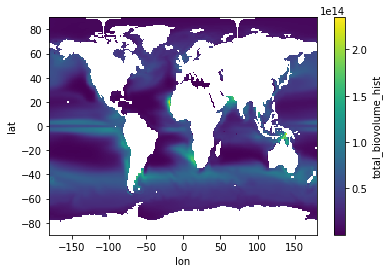

In [60]:
biomes_hist.mean(dim=('time')).total_biovolume_hist.plot()

## Change time format from 365_day to day-month-year

In [61]:
biomes_hist=biomes_hist.assign_coords(year = np.trunc(biomes_hist.time).astype(int))#.astype(int)
biomes_hist=biomes_hist.assign_coords(day = ((biomes_hist.time - biomes_hist.year)*365).astype(int))
biomes_hist = biomes_hist.where(biomes_hist.day !=0, drop=True)

biomes_hist=biomes_hist.assign_coords(year = biomes_hist.year.astype(str))
biomes_hist=biomes_hist.assign_coords(day = np.char.zfill(biomes_hist.day.astype(str),3))



In [62]:
biomes_hist=biomes_hist.assign_coords(time = np.char.add(np.char.add(biomes_hist.year, '-'),biomes_hist.day))
#ds_hist=ds_hist.assign_coords(time = ds_hist.str.cat(ds_hist.year,ds_hist.day, sep = '-'))

In [63]:
biomes_hist= biomes_hist.drop_dims('day')
biomes_hist = biomes_hist.drop('year', dim=None)

In [64]:
#sorted(ds_hist.time.values)

In [65]:
from datetime import datetime as dt
biomes_hist=biomes_hist.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in biomes_hist.time.values])

#ds_hist['time'].dt.strftime('%y%j')

In [66]:
biomes_hist = biomes_hist.sortby('time', ascending = True)

In [67]:
biomes_hist

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 1985-01-16 ... 2014-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/19)
    biomes                (lat, lon, time) float64 nan nan nan ... 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 1.721e-08 1.721e-08 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan nan ... 71.04
    total_biovolume_hist  (time, lat, lon) float64 nan nan ... 1.809e+12
    betas_hist            (time, lat, lon) float64 nan nan nan ... -1.098 -1.098
    intercept_hist        (time, lat, lon) float64 nan nan ... 1.67e+12
    ...                    ...
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 36.02 36.02
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 49.26 49.26
    zmicro_per            (time, lat, lon) float64 nan nan nan ... 3.849 3.851
    zmeso_per             (time, lat, lon) float64 nan nan nan ... 10.87 10.87
    phyc                  (time, lat, lon) float64 nan nan ... 1.318e+13
    zooc                  (time, lat, lon) float64 nan nan ... 2.274e+12

In [68]:
np.nanmin(biomes_hist.total_biovolume_hist.values)

130.50786371944665

In [69]:
biomes_hist.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_hist_biovolume.nc')

<h1><center> SAME PROCESS BUT FOR SSP5 8.5</center></h1>

## Pre step: combine the different files of the plankton into one netcdf file

In [70]:


# combine ssp5 data in one file and add variables by depth, and remove old datasets
ds_ssp585= xr.open_mfdataset(files_ssp585, combine = 'by_coords')

for i in [ 'phydiat', 'phymisc', 'zmicro', 'zmeso']:
    ds_ssp585[i+'_200']= ds_ssp585[i+'_200'].fillna(0)
    ds_ssp585[i +'_0_200'] = ds_ssp585[i +'_100'] + ds_ssp585[i+'_200']
    ds_ssp585 = ds_ssp585.drop_vars([i+'_100', i+'_200'])
ds_ssp585=ds_ssp585.sel(time= slice(2069.9, 2100.0)) # some data earlier than 1984 had to be removed
ds_ssp585=ds_ssp585.sortby('lat', ascending=True)
ds_ssp585

<xarray.Dataset>
Dimensions:        (time: 360, lon: 360, lat: 180)
Coordinates:
  * time           (time) float64 2.07e+03 2.07e+03 2.07e+03 ... 2.1e+03 2.1e+03
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    phydiat_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    phymisc_0_200  (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    zmicro_0_200   (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>
    zmeso_0_200    (time, lat, lon) float64 dask.array<chunksize=(360, 180, 360), meta=np.ndarray>

In [71]:
#necessary step to make sure that cells with Nans are the same across the PFTs
ds_ssp585_mask = ~(np.isnan(ds_ssp585.phydiat_0_200) | np.isnan(ds_ssp585.phymisc_0_200) | np.isnan(ds_ssp585.zmicro_0_200) | np.isnan(ds_ssp585.zmeso_0_200))
ds_ssp585 = ds_ssp585.where(ds_ssp585_mask)

In [72]:
carbon_molar_mass = 12.011 # g/mol
# dictionary with total carbon
total_carbon_gC_ssp585={}
total_carbon_gC_ssp585['globalSum_gC']={}
total_carbon_gC_ssp585['globalSum_gC']['phymisc'] = ((ds_ssp585.phymisc_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['phydiat'] = ((ds_ssp585.phydiat_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['zmeso'] = ((ds_ssp585.zmeso_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585['globalSum_gC']['zmicro'] = ((ds_ssp585.zmicro_0_200.mean(dim='time')) * area_grid.areacello).sum(dim=['lon','lat']).values * carbon_molar_mass # g C
total_carbon_gC_ssp585

{'globalSum_gC': {'phymisc': 507314007655564.7,
  'phydiat': 165080920986364.66,
  'zmeso': 239355932186533.56,
  'zmicro': 238322411876250.28}}

In [73]:
# transform the dictionary to a dataframe
biomass_ssp585=pd.DataFrame.from_dict(total_carbon_gC_ssp585)
biomass_ssp585=biomass_ssp585.reset_index()
biomass_ssp585.columns.values[0]='name'
biomass_ssp585

,name,globalSum_gC
0,phydiat,1.650809e+14
1,phymisc,5.073140e+14
2,zmeso,2.393559e+14
3,zmicro,2.383224e+14


In [74]:
global_um3_list = []
for n, v in enumerate(biomass_ssp585.name.unique()):
    global_um3_list.append(g_carbon_to_biovol(biomass_ssp585.globalSum_gC[n], v))
biomass_ssp585['globalSum_um3'] = global_um3_list

In [75]:
biomass_ssp585

,name,globalSum_gC,globalSum_um3
0,phydiat,1.650809e+14,6.577247e+30
1,phymisc,5.073140e+14,1.277575e+31
2,zmeso,2.393559e+14,1.234265e+28
3,zmicro,2.383224e+14,7.496404e+27


In [76]:
sizedf_ssp585=pd.DataFrame([10**sizes]).transpose()
sizedf_ssp585.columns=['sizes']
sizedf_ssp585['phyto']= None
sizedf_ssp585['zoo']= None
#sizedf.loc[sizedf.sizes < 10,'phyto']='smp'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 2) & (sizedf_ssp585.sizes < 20),'phyto']='phymisc'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 20) & (sizedf_ssp585.sizes < 100),'phyto']='phydiat' ##Playing with diatom size 
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 10) & (sizedf_ssp585.sizes < 200),'zoo']='zmicro'
sizedf_ssp585.loc[(sizedf_ssp585.sizes > 200) & (sizedf_ssp585.sizes < 2000),'zoo']='zmeso'

sizedf_ssp585

,sizes,phyto,zoo
0,2.000000,None,None
1,2.013863,phymisc,None
2,2.027823,phymisc,None
3,2.041879,phymisc,None
4,2.056033,phymisc,None
...,...,...,...
995,1932.101758,None,zmeso
996,1945.494448,None,zmeso
997,1958.979971,None,zmeso
998,1972.558971,None,zmeso


In [77]:
# determine the degree of overlap between size bins. In COBALT (and perhaps other models) the degree of overlap might need to be determined following 
# Jessica's method

# the goal is to have repeated entries for a size class if it occurs across plantkon types:
sdfm_ssp585 = pd.melt(sizedf_ssp585, id_vars='sizes',var_name='type',value_name='name')
sdfm_ssp585 = sdfm_ssp585.dropna().reset_index(drop=True)
#pd.set_option('display.max_rows',80)
sdfm_ssp585

,sizes,type,name
0,2.013863,phyto,phymisc
1,2.027823,phyto,phymisc
2,2.041879,phyto,phymisc
3,2.056033,phyto,phymisc
4,2.070284,phyto,phymisc
...,...,...,...
1328,1932.101758,zoo,zmeso
1329,1945.494448,zoo,zmeso
1330,1958.979971,zoo,zmeso
1331,1972.558971,zoo,zmeso


In [78]:
# assign biovolume and amount of acrbon to each size bin
import math

sdfm_ssp585['biovolume_um3']=(4/3)*math.pi*(sdfm_ssp585.sizes/2)**3

sdfm_ssp585['mg_carbon']=0


# phymisc, which are non diatoms, treated as protists, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 < 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 >= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phymisc') & (sdfm_ssp585.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


# zmicro, treated as protists, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp=sdfm_ssp585.loc[(sdfm_ssp585.name=='zmicro') & (sdfm_ssp585.biovolume_um3 < 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='zmicro') & (sdfm_ssp585.biovolume_um3 < 3000),'mg_carbon']=10**(-0.583 + 0.860 * np.log10(tmp)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp=sdfm_ssp585.loc[(sdfm.name=='zmicro') & (sdfm_ssp585.biovolume_um3 >= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='zmicro') & (sdfm_ssp585.biovolume_um3 >= 3000),'mg_carbon']=10**(-0.665 + 0.939 * np.log10(tmp)) * 1e-9


#sdfm.loc[sdfm.name=='phymisc','mg_carbon']=0.216 * sdfm.loc[sdfm.name=='phymisc','biovolume_um3']**0.939 * 1e-9
#sdfm.loc[sdfm.name=='zmicro','mg_carbon']=0.216 * sdfm.loc[sdfm.name=='zmicro','biovolume_um3']**0.939 * 1e-9

# diatoms, Menden-Deuer and Lessard 2000
# < 3000 um3 biovolume
tmp_ssp585=sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 <= 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 <= 3000),'mg_carbon']=10**(-0.541 + 0.811 * np.log10(tmp_ssp585)) * 1e-9
# > 3000 um3 biovolume OJO under current size classes, all phydiat will fit here. This might be a big source of biomass overestimation
tmp_ssp585=sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 > 3000),'biovolume_um3']
sdfm_ssp585.loc[(sdfm_ssp585.name=='phydiat') & (sdfm_ssp585.biovolume_um3 > 3000),'mg_carbon']=10**(-0.933 + 0.881 * np.log10(tmp_ssp585)) * 1e-9

# mesozooplankton, Pitt et al. 2013 will be deprecated, we will use Kiorboe (2013)/Maas et al. (2021) combo
#sdfm.loc[sdfm.name=='zmeso','mg_carbon']= 0.06281 * (sdfm.loc[sdfm.name=='zmeso','sizes']/1e3)**3
sdfm_ssp585.loc[sdfm_ssp585.name=='zmeso','mg_carbon'] = 0.055 * (sdfm_ssp585.loc[sdfm.name=='zmeso','biovolume_um3']/1e9) # Maas et al. takes milimeters cubed (notice conversion) and returns dry mass in mg
sdfm_ssp585.loc[sdfm_ssp585.name=='zmeso','mg_carbon'] = 10**((np.log10(sdfm_ssp585.loc[sdfm_ssp585.name=='zmeso','mg_carbon'])-(-0.67))/0.96) # Kiorboe et al. takes dry mass in mg to wet mass in mg
sdfm_ssp585.loc[sdfm_ssp585.name=='zmeso','mg_carbon'] = (10**((0.95*np.log10(sdfm_ssp585.loc[sdfm_ssp585.name=='zmeso','mg_carbon']))-0.93))# Kiorboe et al. takes wet mass  and returns mass of carbon
#sdfm_ssp585

## Step 3. pull together and merge the overlapping size bins. The total global carbon is split by the size bins.. yes?

In [79]:

sdfm_ssp585['globalSum_um3_split']=0
for s in p_categories:
    n=len(sdfm_ssp585.loc[sdfm.name==s].index)
    print(s, n)
    sdfm_ssp585.loc[sdfm_ssp585.name==s,'globalSum_um3_split'] = np.tile(biomass_ssp585.loc[biomass_ssp585.name==s,'globalSum_um3']/n,n)
sdfm_ssp585

phymisc 333
phydiat 233
zmeso 333
zmicro 434


,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phymisc,4.276501e+00,9.114570e-10,3.836562e+28
1,2.027823,phyto,phymisc,4.366049e+00,9.278466e-10,3.836562e+28
2,2.041879,phyto,phymisc,4.457472e+00,9.445310e-10,3.836562e+28
3,2.056033,phyto,phymisc,4.550809e+00,9.615153e-10,3.836562e+28
4,2.070284,phyto,phymisc,4.646101e+00,9.788051e-10,3.836562e+28
...,...,...,...,...,...,...
1328,1932.101758,zoo,zmeso,3.776492e+09,1.141779e-01,3.706500e+25
1329,1945.494448,zoo,zmeso,3.855570e+09,1.165436e-01,3.706500e+25
1330,1958.979971,zoo,zmeso,3.936304e+09,1.189582e-01,3.706500e+25
1331,1972.558971,zoo,zmeso,4.018728e+09,1.214229e-01,3.706500e+25


In [80]:
sdfm_ssp585 = sdfm_ssp585.sort_values(by='biovolume_um3', ascending=True)


In [81]:
sdfm_ssp585

,sizes,type,name,biovolume_um3,mg_carbon,globalSum_um3_split
0,2.013863,phyto,phymisc,4.276501e+00,9.114570e-10,3.836562e+28
1,2.027823,phyto,phymisc,4.366049e+00,9.278466e-10,3.836562e+28
2,2.041879,phyto,phymisc,4.457472e+00,9.445310e-10,3.836562e+28
3,2.056033,phyto,phymisc,4.550809e+00,9.615153e-10,3.836562e+28
4,2.070284,phyto,phymisc,4.646101e+00,9.788051e-10,3.836562e+28
...,...,...,...,...,...,...
1328,1932.101758,zoo,zmeso,3.776492e+09,1.141779e-01,3.706500e+25
1329,1945.494448,zoo,zmeso,3.855570e+09,1.165436e-01,3.706500e+25
1330,1958.979971,zoo,zmeso,3.936304e+09,1.189582e-01,3.706500e+25
1331,1972.558971,zoo,zmeso,4.018728e+09,1.214229e-01,3.706500e+25


In [82]:
small_increment = (sdfm_ssp585['biovolume_um3'][1]-sdfm_ssp585['biovolume_um3'][0])/2 # small increment is used to define the maximum and minimum of the size rang

In [83]:
# create log-spaced bins for mg_carbon
bins = np.logspace(np.log10(sdfm_ssp585['biovolume_um3'].min()-small_increment), np.log10(sdfm_ssp585['biovolume_um3'].max()+small_increment), 51)

# use pandas.cut to bin the data into log-spaced bins
sdfm_ssp585['biovolume_um3_bin'] = pd.cut(sdfm_ssp585['biovolume_um3'], bins=bins, include_lowest=False)
sdfm_ssp585['bin_centers'] = sdfm_ssp585['biovolume_um3_bin'].apply(lambda x:x.mid).astype(float) # this gets the mid point 
sdfm_ssp585['bin_range'] = sdfm_ssp585['biovolume_um3_bin'].apply(lambda x:x.length).astype(float)

len(sdfm_ssp585)

1333

In [84]:
df_grouped_ssp585 = sdfm_ssp585.groupby(['biovolume_um3_bin','bin_centers','bin_range', 'name']).agg(biovolume_um3=('biovolume_um3','mean'),
                                                                      sizes=('sizes','mean'))
df_grouped_ssp585 = df_grouped_ssp585.dropna().reset_index()
len(df_grouped_ssp585)

70

In [85]:
df_grouped_ssp585

,biovolume_um3_bin,bin_centers,bin_range,name,biovolume_um3,sizes
0,"(4.232, 6.401]",5.316500e+00,2.169000e+00,phymisc,5.244268e+00,2.152160
1,"(6.401, 9.682]",8.041500e+00,3.281000e+00,phymisc,7.937521e+00,2.471010
2,"(9.682, 14.646]",1.216400e+01,4.964000e+00,phymisc,1.201392e+01,2.837099
3,"(14.646, 22.154]",1.840000e+01,7.508000e+00,phymisc,1.818381e+01,3.257425
4,"(22.154, 33.51]",2.783200e+01,1.135600e+01,phymisc,2.752231e+01,3.740025
5,"(33.51, 50.688]",4.209900e+01,1.717800e+01,phymisc,4.165670e+01,4.294123
6,"(50.688, 76.672]",6.368000e+01,2.598400e+01,phymisc,6.304997e+01,4.930313
7,"(76.672, 115.976]",9.632400e+01,3.930400e+01,phymisc,9.542999e+01,5.660756
8,"(115.976, 175.429]",1.457025e+02,5.945300e+01,phymisc,1.444391e+02,6.499418
9,"(175.429, 265.358]",2.203935e+02,8.992900e+01,phymisc,2.186175e+02,7.462330


In [86]:
bin_info_ssp585 = pd.DataFrame({
    'biovolume_um3_bin': np.sort(sdfm_ssp585['biovolume_um3_bin'].unique()),
    'bin_centers': np.sort(sdfm_ssp585['bin_centers'].unique())})

## Calculate  total biomass and normalized biomass per size class

In [87]:
lat = ds_ssp585.lat
lon = ds_ssp585.lon
time = ds_ssp585.time
biovol_um3 = bin_info_ssp585.bin_centers
data_ssp585 = np.zeros((len(biovol_um3), len(time), len(lat), len(lon)))
biovolume_all_ssp585 = xr.DataArray(data_ssp585, coords={'biovol_um3':biovol_um3, 'time':time, 'lat':lat, 'lon':lon},
            dims = ['biovol_um3', 'time','lat', 'lon'])

lat_NB = ds_ssp585.lat
lon_NB = ds_ssp585.lon
time_NB = ds_ssp585.time
biovol_um3_NB = bin_info_ssp585.bin_centers
data_ssp585_NB = np.zeros((len(biovol_um3_NB), len(time_NB), len(lat_NB), len(lon_NB)))
biovolume_all_ssp585_NB = xr.DataArray(data_ssp585_NB, coords={'biovol_um3':biovol_um3_NB, 'time':time_NB, 'lat':lat_NB, 'lon':lon_NB},
            dims = ['biovol_um3', 'time','lat', 'lon'])

#time = ds.time
#data = np.zeros((len(time), len(mmolC), len(z_t_150m), len(nlat), len(nlon)))
#biomass_all = xr.DataArray(data, coords={'time':time, 'mass_mmolC':mmolC, 'z_t_150m':z_t_150m, 'nlat':nlat, 'nlon':nlon},
#            dims = ['time', 'mass_mmolC', 'z_t_150m', 'nlat', 'nlon'])


biovolume_all_ssp585.shape

(50, 360, 180, 360)

In [88]:
biovolume_all_ssp585_NB.shape

(50, 360, 180, 360)

In [89]:
biovolume_all_ssp585 = size_spectra(biovolume_all_ssp585, ds_ssp585, NB=False)

phymisc
120891972687404.42
zmicro
6403608210276.76
phydiat
790803949341077.2
zmeso
17681368518257.453


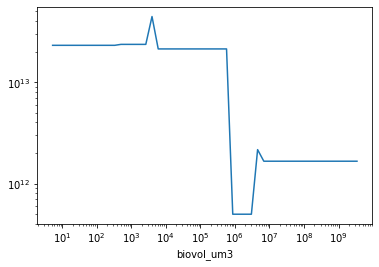

In [90]:
biovolume_all_ssp585.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

## Get the total biovolume for only the size range included in PSSdb UVP+Zooscan

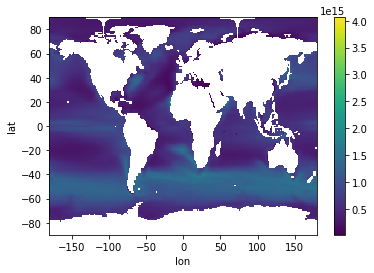

In [91]:
biovol_mask_ssp585 = ~np.isnan(biovolume_all_ssp585.mean(dim=('biovol_um3')))
biovolume_all_subset_ssp585= biovolume_all_ssp585.where((biovolume_all_ssp585['biovol_um3']>826400.0) & (biovolume_all_ssp585['biovol_um3']<49100000000000.0)).sum(dim=['biovol_um3'])
biovolume_all_ssp585= biovolume_all_ssp585.sum(dim=['biovol_um3'])
biovolume_all_ssp585 = biovolume_all_ssp585.where(biovol_mask_ssp585)
biovolume_all_subset_ssp585 = biovolume_all_subset_ssp585.where(biovol_mask_ssp585)
biovolume_all_ssp585.mean(dim=('time')).plot()

                               

In [92]:
biovolume_all_ssp585_NB = size_spectra(biovolume_all_ssp585_NB, ds_ssp585, NB=True)

phymisc
55736271409591.72
zmicro
31121583829.184147
phydiat
485342490234.6347
zmeso
9551271.081121689


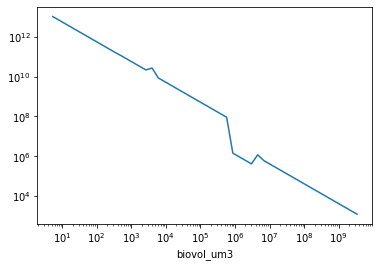

In [93]:
biovolume_all_ssp585_NB.mean(dim=('lat', 'lon', 'time')).plot()
plt.xscale('log')
plt.yscale('log')

In [94]:
# removing data from mediterranean and black sea
#biovolume_all_ssp585.loc[dict(lat=biovolume_all_ssp585.coords['lat'][(biovolume_all_ssp585.coords['lat'] >= 30.5) & (biovolume_all_ssp585.coords['lat'] <= 47.5)],
                                        #lon=biovolume_all_ssp585.coords['lon'][(biovolume_all_ssp585.coords['lon'] >= -5.5) & (biovolume_all_ssp585.coords['lon'] <= 55.5)])]=float('nan')#

In [95]:
betas_ssp5, intercept_ssp5, R2_ssp5, RMSE_ssp5 = calculate_size_spectra_slopes(biovolume_all_ssp585_NB)
betas_ssp5.shape

(360, 180, 360)

In [96]:
np.nanmean(betas_ssp5)

-1.2461772629152703

In [97]:
biovolume_all_ssp585_NB.values=10**(biovolume_all_ssp585_NB.values)

In [98]:
#phymisc=g_carbon_to_biovol(((ds_ssp585.phymisc_0_200.values)*carbon_molar_mass), 'phymisc')
#phydiat=g_carbon_to_biovol(((ds_ssp585.phydiat_0_200.values)*carbon_molar_mass), 'phydiat')
#zmicro=g_carbon_to_biovol(((ds_ssp585.zmicro_0_200.values)*carbon_molar_mass), 'zmicro')
#zmeso=g_carbon_to_biovol(((ds_ssp585.zmeso_0_200.values)*carbon_molar_mass), 'zmeso')



## Get the slopes for each biome

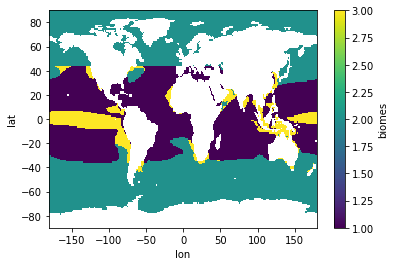

In [99]:
# load the biome mask
biome_mask = '/work/jyl/proj/CMIP6_models/ESM_Biomes/UKESM_ssp585_biomes_x1.nc'
biomes_ssp5 = xr.open_dataset(biome_mask)
biomes_ssp5 = xr.open_dataset(biome_mask)
biomes_mask = ~np.isnan(biomes_ssp5.biomes)
biomes_ssp5['biomes'] = biomes_ssp5['biomes'].where((biomes_ssp5['lat'] > -44.5) & (biomes_ssp5['lat'] < 44.5), 2)
biomes_ssp5 = biomes_ssp5.where(biomes_mask)
#biomes_ssp5 = biomes_ssp5.assign_coords(lat=(biomes_ssp5.lat * -1))
biomes_ssp5.biomes.plot()

In [100]:

# add slopes to the biomes dataset
biomes_ssp5['chl'] = (('time', 'lat', 'lon'), chl_ssp5.schl.values)
biomes_ssp5['chl'].attrs = {"units": 'kg m-3', 'Description': 'Surface Mass Concentration of Total Phytoplankton expressed as Chlorophyll in Sea Water'}

biomes_ssp5['NB'] = biovolume_all_ssp585_NB
biomes_ssp5['NB'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'normalized biovolume for each size class'}

#biomes_ssp5['total_biovolume_ssp5_full'] = biovolume_all
biomes_ssp5['total_biovolume_ssp5'] = biovolume_all_subset_ssp585#(('time', 'lat', 'lon'),biovolume_all.values)
biomes_ssp5['total_biovolume_ssp5'] = biomes_ssp5.total_biovolume_ssp5.where(biomes_ssp5['total_biovolume_ssp5'] > 50)
biomes_ssp5['total_biovolume_ssp5'].attrs = {"units": 'um^3 ', 'Description': 'total biovolume from the size range of 116-2000 micrometers'}

biomes_ssp5['betas_ssp5'] = (('time', 'lat', 'lon'), betas_ssp5)
biomes_ssp5['betas_ssp5'].attrs = {"units": 'm^-2 m^-3', 'Description': 'Normalized biovolume size spectra slope'}

biomes_ssp5['intercept_ssp5'] = (('time', 'lat', 'lon'), intercept_ssp5)
biomes_ssp5['intercept_ssp5'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra intercept'}

biomes_ssp5['R2_ssp5'] = (('time', 'lat', 'lon'), R2_ssp5)
biomes_ssp5['R2_ssp5'].attrs = { 'Description': 'Normalized biovolume coefficient of determination'}

biomes_ssp5['RMSE_ssp5'] = (('time', 'lat', 'lon'), RMSE_ssp5)
biomes_ssp5['RMSE_ssp5'].attrs = {"units": 'um^3 m^-2 m^-3', 'Description': 'Normalized biovolume size spectra Root mean square error'}

#original_biomass_variables
biomes_ssp5['phymisc'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.phymisc_0_200.values*carbon_molar_mass, 'phymisc'))
biomes_ssp5['phymisc'].attrs = {"units": 'um^3', 'Description': 'miscellaneous phytoplankton biovolume'}

biomes_ssp5['phydiat'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.phydiat_0_200.values*carbon_molar_mass, 'phydiat'))
biomes_ssp5['phydiat'].attrs = {"units": 'um^3', 'Description': 'diatom biovolume'}

biomes_ssp5['zmicro'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.zmicro_0_200.values*carbon_molar_mass, 'zmicro'))
biomes_ssp5['zmicro'].attrs = {"units": 'um^3', 'Description': 'microzooplankton biovolume'}

biomes_ssp5['zmeso'] = (('time', 'lat', 'lon'),g_carbon_to_biovol(ds_ssp585.zmeso_0_200.values*carbon_molar_mass, 'zmeso'))
biomes_ssp5['zmeso'].attrs = {"units": 'um^3', 'Description': 'mesozooplankton biovolume'}

biomes_ssp5['total_biovolume_full']=(('time', 'lat', 'lon'), biomes_ssp5.phymisc.values+biomes_ssp5.phydiat.values+biomes_ssp5.zmicro.values+biomes_ssp5.zmeso.values)
biomes_ssp5['total_biovolume_full'].attrs = {"units": 'um^3', 'Description': 'all plankton biovolume'}
                                          
#percentage total
biomes_ssp5['phymisc_per'] = (('time', 'lat', 'lon'), (biomes_ssp5.phymisc.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['phymisc_per'].attrs = {'Description': 'miscellaneous phytoplankton percentage of total biovolume'}                                        
                                          
biomes_ssp5['phydiat_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.phydiat.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['phydiat_per'].attrs = {'Description': 'diatom percentage of total biovolume'}                                           
                                          
biomes_ssp5['zmicro_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.zmicro.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['zmicro_per'].attrs = {'Description': 'microzooplankton percentage of total biovolume'} 

biomes_ssp5['zmeso_per'] = (('time', 'lat', 'lon'),(biomes_ssp5.zmeso.values/biomes_ssp5.total_biovolume_full.values)*100)
biomes_ssp5['zmeso_per'].attrs = {'Description': 'mesozooplankton percentage of total biovolume'} 

#total biovolume
biomes_ssp5['phyc'] = (('time', 'lat', 'lon'), biomes_ssp5.phymisc.values+biomes_ssp5.phydiat.values)
biomes_ssp5['phyc'].attrs = {"units": 'um^3', 'Description': 'phytoplankton biovolume'}

biomes_ssp5['zooc'] = (('time', 'lat', 'lon'), biomes_ssp5.zmicro.values+biomes_ssp5.zmeso.values)
biomes_ssp5['zooc'].attrs = {"units": 'um^3', 'Description': 'zooplankton biovolume'}

#biomes_ssp5['total_biovolume_ssp5']= (('time', 'lat', 'lon'), phypico+phydiat+zooc)
biomes_ssp5

<xarray.Dataset>
Dimensions:               (time: 360, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) float64 2.07e+03 2.07e+03 ... 2.1e+03 2.1e+03
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/19)
    biomes                (lat, lon) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 1.759e-08 1.758e-08 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan nan ... 69.5
    total_biovolume_ssp5  (time, lat, lon) float64 nan nan ... 1.792e+12
    betas_ssp5            (time, lat, lon) float64 nan nan nan ... -1.144 -1.144
    intercept_ssp5        (time, lat, lon) float64 nan nan ... 3.864e+12
    ...                    ...
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 47.08 47.07
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 43.0 43.01
    zmicro_per            (time, lat, lon) float64 nan nan nan ... 2.925 2.925
    zmeso_per             (time, lat, lon) float64 nan nan nan ... 6.993 6.993
    phyc                  (time, lat, lon) float64 nan nan ... 2.116e+13
    zooc                  (time, lat, lon) float64 nan nan ... 2.33e+12

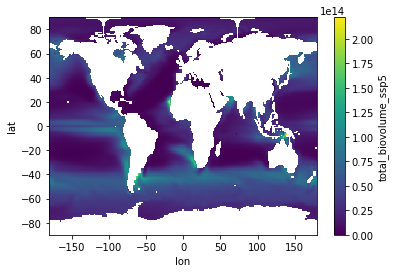

In [101]:
biomes_ssp5.mean(dim=('time')).total_biovolume_ssp5.plot()

## Change time format from 365_day to day-month-year

In [102]:
biomes_ssp5=biomes_ssp5.assign_coords(year = np.trunc(biomes_ssp5.time).astype(int))#.astype(int)
biomes_ssp5=biomes_ssp5.assign_coords(day = ((biomes_ssp5.time - biomes_ssp5.year)*365).astype(int))
biomes_ssp5 = biomes_ssp5.where(biomes_ssp5.day !=0, drop=True)

biomes_ssp5=biomes_ssp5.assign_coords(year = biomes_ssp5.year.astype(str))
biomes_ssp5=biomes_ssp5.assign_coords(day = np.char.zfill(biomes_ssp5.day.astype(str),3))



In [103]:
biomes_ssp5=biomes_ssp5.assign_coords(time = np.char.add(np.char.add(biomes_ssp5.year, '-'),biomes_ssp5.day))
#ds_hist=ds_hist.assign_coords(time = ds_hist.str.cat(ds_hist.year,ds_hist.day, sep = '-'))

In [104]:
biomes_ssp5= biomes_ssp5.drop_dims('day')
biomes_ssp5 = biomes_ssp5.drop('year', dim=None)

In [105]:
#sorted(ds_hist.time.values)

In [106]:
from datetime import datetime as dt
biomes_ssp5=biomes_ssp5.assign_coords(time = [dt.strptime(x, '%Y-%j') for x in biomes_ssp5.time.values])

#ds_hist['time'].dt.strftime('%y%j')

In [107]:
biomes_ssp5 = biomes_ssp5.sortby('time', ascending = True)

In [108]:
biomes_ssp5

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360, time: 360, biovol_um3: 50)
Coordinates:
  * time                  (time) datetime64[ns] 2070-01-16 ... 2099-12-16
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.316 8.041 ... 3.408e+09
Data variables: (12/19)
    biomes                (lat, lon, time) float64 nan nan nan ... 2.0 2.0 2.0
    chl                   (time, lat, lon) float64 1.759e-08 1.758e-08 ... nan
    NB                    (biovol_um3, time, lat, lon) float64 nan nan ... 69.5
    total_biovolume_ssp5  (time, lat, lon) float64 nan nan ... 1.792e+12
    betas_ssp5            (time, lat, lon) float64 nan nan nan ... -1.144 -1.144
    intercept_ssp5        (time, lat, lon) float64 nan nan ... 3.864e+12
    ...                    ...
    phymisc_per           (time, lat, lon) float64 nan nan nan ... 47.08 47.07
    phydiat_per           (time, lat, lon) float64 nan nan nan ... 43.0 43.01
    zmicro_per            (time, lat, lon) float64 nan nan nan ... 2.925 2.925
    zmeso_per             (time, lat, lon) float64 nan nan nan ... 6.993 6.993
    phyc                  (time, lat, lon) float64 nan nan ... 2.116e+13
    zooc                  (time, lat, lon) float64 nan nan ... 2.33e+12

In [109]:
biomes_ssp5.to_netcdf('/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_ssp5_biovolume.nc')

## include code to assess the size spectra

In [110]:
from wcmatch.pathlib import Path # Handling of path object

In [111]:
test_df = biomes_hist.mean(dim=['time']).to_dataframe()
test_df=test_df.dropna().reset_index()
test_df=test_df.drop_duplicates().reset_index(drop=True)
test_df['biomes'] = test_df['biomes'].astype(str)
test_df = test_df.replace({'biomes':{'1.0':'LC','2.0':'HCSS','3.0':'HCPS'}})

In [112]:
import math as m
test_df['source']='UKESM'
test_df['ECD'] = ((test_df['biovol_um3']*6)/m.pi)**(1./3.)
test_df=test_df.astype(dict(zip(['biovol_um3', 'ECD'],[str]*2))).groupby(['source', 'biovol_um3', 'ECD']).apply(lambda x: pd.Series({'NB':np.nanmean(x.NB)})).reset_index()
test_df['biovol_um3']=test_df['biovol_um3'].astype(float)
test_df['ECD']=test_df['ECD'].astype(float)
test_df

,source,biovol_um3,ECD,NB
0,UKESM,1.038042e+07,270.648418,4.866239e+05
1,UKESM,1.094383e+05,59.345841,5.219373e+08
2,UKESM,1.153783e+03,13.012930,5.390821e+10
3,UKESM,1.216400e+01,2.853378,5.004001e+12
4,UKESM,1.243379e+08,619.253300,4.062608e+04
5,UKESM,1.310865e+06,135.785417,1.008690e+06
6,UKESM,1.382014e+04,29.774051,4.133095e+09
7,UKESM,1.457025e+02,6.528641,4.178067e+11
8,UKESM,1.489334e+09,1416.873790,3.391692e+03
9,UKESM,1.570169e+07,310.681909,3.217081e+05


In [113]:
bins_df = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/ecopart_size_bins.csv', sep = ',')
test_df.loc[:, 'sizeClasses']= pd.cut(x=test_df['ECD'], bins=bins_df['ESD_um'], include_lowest=True)# size classes defined by biovolume
test_df['ECD'] = test_df.sizeClasses.apply(lambda x: x.mid)
test_df=test_df.drop(columns=['sizeClasses']).reset_index()
test_df['NB']=(test_df['NB']/200)*0.001# conversion to liters

In [114]:
from plotnine import *
colors = dict(CESM= 'red',CMCC= 'cyan', CNRM= 'gray',GFDL= 'lawngreen',IPSL= 'gold',UKESM= 'purple', PSSdb = 'blue')
breaks = [20, 200, 2000, 20000]#breaks = [1, 2, 20, 200]#
labels = [20, 200, 2000, 20000]#labels = [1, 2, 20, 200]#
theme_paper=theme(axis_ticks_direction="inout",
              panel_grid=element_blank(),
              axis_line = element_line(colour = "black"),
              panel_background=element_rect(fill='white'),
              panel_border=element_blank(),
              legend_title=element_text(family="serif", size=15),
              legend_position='none',#legend_position='top',
              legend_text=element_text(family="serif", size=15),
              axis_title=element_text(family="serif", size=15),
              axis_text_x=element_text(family="serif", size=15),
              axis_text_y=element_text(family="serif", size=15, rotation=90),
              plot_background=element_rect(fill='white'), strip_background=element_rect(fill='white'))

In [115]:
test_df['ECD']=test_df['ECD'].astype(float)

In [116]:
plot = (ggplot(data=test_df)+
        geom_line(test_df,aes(x='ECD', y='NB', color='source', group='source'),  size = 1) +
        geom_point(aes(x='ECD', y='NB',color='source', group='source'),size = 3,  shape = 'o')+
        #stat_summary(data=df_NB[df_NB.ECD.transform(lambda x: x.astype(str).isin(pd.Series(x.value_counts(normalize=True)[x.value_counts(normalize=True)>=np.quantile(x.value_counts(normalize=True),0.5)].index).astype(str)))],mapping=aes(x='ECD', y='NB'),geom='line', fun_y=np.nanmedian, size = 0.5, alpha=0.5)+
        #stat_summary(mapping=aes(x='ECD', y='NB'),geom='line', fun_y=np.nanmedian, size = 0.8)+
        labs(y=r'Normalized Biovolume ($\mu$m$^{3}$ m$^{-2}$ $\mu$m$^{-3}$)', x=r'Equivalent circular diameter ($\mu$m)')+
        scale_color_manual(values = colors)+
        scale_y_log10(breaks=[10**np.arange(-5,10,step=2, dtype=np.float)][0],labels=['10$^{%s}$'% int(n) for n in np.arange(-5,10,step=2)] , limits=(1e-5, 1e11))+
        #scale_y_log10(breaks=[10**np.arange(-5,-3,step=0.5, dtype=np.float)][0],labels=['10$^{%s}$'% int(n) for n in np.arange(-5,-3,step=0.5)] , limits=(1e-5, 1e-3))+
        scale_x_log10(breaks=breaks, labels=labels,limits=(0.5, 35000))+
        #scale_x_log10(breaks=[size  for size in np.sort( np.concatenate(np.arange(1, 10).reshape((9, 1)) * np.power(10, np.arange(1, 5, 1))))],labels= [size if (size / np.power(10, np.ceil(np.log10(size)))) == 1 else '' for size in np.sort( np.concatenate(np.arange(1, 10).reshape((9, 1)) * np.power(10, np.arange(1, 5, 1))))], limits=(1, 15000))+
        theme_paper).draw(show=False)
plot.set_size_inches(6,6)
plot.savefig(fname='{}/work/CMIP6_size_spectra_scripts/plots/NBSS_UKESM_mean.pdf'.format(str(Path.home())), dpi=300)